## Post Generator

In [10]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, Literal, Annotated
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import operator

load_dotenv()

Gemini = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite')

In [12]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [16]:
# Define State
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

# Creating Nodes
def generateTweet(state: TweetState):
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""Write a short, original, and hilarious tweet on the topic: "{state['topic']}".
                Rules:
                - Do NOT use question-answer format.
                - Max 280 characters.
                - Use observational humor, irony, sarcasm, or cultural references.
                - Think in meme logic, punchlines, or relatable takes.
                - Use simple, day to day english""")
            ]

    # send generator_llm
    response = Gemini.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

def evaluateTweet(state: TweetState):
    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""Evaluate the following tweet:

            Tweet: "{state['tweet']}"

            Use the criteria below to evaluate the tweet:

            1. Originality – Is this fresh, or have you seen it a hundred times before?  
            2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
            3. Punchiness – Is it short, sharp, and scroll-stopping?  
            4. Virality Potential – Would people retweet or share it?  
            5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

            Auto-reject if:
            - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
            - It exceeds 280 characters
            - It reads like a traditional setup-punchline joke
            - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

            ### Respond ONLY in structured format:
            - evaluation: "approved" or "needs_improvement"  
            - feedback: One paragraph explaining the strengths and weaknesses """)
        ]

    response = Gemini.with_structured_output(TweetEvaluation).invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

def optimizeTweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""Improve the tweet based on this feedback:
                "{state['feedback']}"

                Topic: "{state['topic']}"
                Original Tweet:
                {state['tweet']}

                Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.""")
            ]   

    response = Gemini.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

def routeEvaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

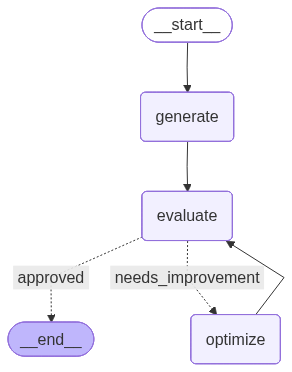

In [17]:
# Create Graph
tweetGraph = StateGraph(TweetState)

# Adding Nodes
tweetGraph.add_node('generate', generateTweet)
tweetGraph.add_node('evaluate', evaluateTweet)
tweetGraph.add_node('optimize', optimizeTweet)

# Connecting Edges
tweetGraph.add_edge(START, 'generate')
tweetGraph.add_edge('generate', 'evaluate')

tweetGraph.add_conditional_edges('evaluate', routeEvaluation, {'approved': END, 'needs_improvement': 'optimize'})
tweetGraph.add_edge('optimize', 'evaluate')

# Compiling
workflow = tweetGraph.compile()
workflow

In [22]:
initial_state = {
    "topic": "mud",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [23]:
result

{'topic': 'mud',
 'tweet': 'Just stepped in mud. Pretty sure I\'m now 70% dirt, 30% pure, unadulterated "oh no." Send a hazmat suit and a therapist. #MuddyMonday',
 'evaluation': 'approved',
 'feedback': 'This tweet is approved. The humor lands well with the relatable "oh no" feeling and the exaggeration of being 70% dirt. The request for a hazmat suit and therapist adds a good punchline. It\'s original enough in its specific phrasing and the hashtag #MuddyMonday is a nice touch. The format is perfect for Twitter, short, punchy, and well within the character limit, giving it good potential for virality as many can relate to the messy mishap.',
 'iteration': 4,
 'max_iteration': 5,
 'tweet_history': ["Just stepped in mud. Pretty sure I'm now 70% dirt, 30% regret. My therapist is gonna have a field day with this. #MuddyMonday #SendWipes",
  'Here are a few options, playing with different angles to address the feedback:\n\n**Option 1 (Focus on unexpected twist):**\n\n> Just stepped in mud